In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.3
#set_session(tf.Session(config=config))
session = tf.Session(config=config)

# Classifiying newswires: Reuters, a multiclass classification example

+ 这个例子整理自[《Deep Learning with Python》](https://book.douban.com/subject/27038207/) 3.5节

## 0.探索数据-Reuters

+ [Reuters](http://www.daviddlewis.com/resources/testcollections/reuters21578/)数据集，本数据库包含来自路透社的11,228条新闻，分为了46个主题。与IMDB库一样，每条新闻被编码为一个词下标的序列。
+ 我们希望输入新闻的内容，得到该新闻的分类，这是一个多类分类问题

In [2]:
from keras.datasets import reuters
from keras.preprocessing import sequence

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from keras import layers
from keras import models
from keras import callbacks
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [3]:
# 导入数据
max_featuers = 10000
(x_train, y_train),(x_test, y_test) = reuters.load_data(num_words=max_featuers)
print('Training data shape:{}, training labels shape:{}'.format(x_train.shape, y_train.shape))
print('Test data shape:{}, test labels shape:{}'.format(x_test.shape, y_test.shape))

Training data shape:(8982,), training labels shape:(8982,)
Test data shape:(2246,), test labels shape:(2246,)


In [4]:
# 显示部分数据
#print('No.\t\tLength\t\tContent(the first 10 words)\t\t\t\tTarget')
print('{:<6}{:<10}{:<60}{:<10}'.format('No.', 'Length', 'Content(first 10 words)', 'Targets'))
for i, (x,y) in enumerate(zip(x_train[:20], y_train[:20])):
    #target = 'Positive'if y==1 else 'Negative'
    print('{:<6}{:<10}{:<60}{:<10}'.format(i, len(x), str(x[:10]), y))

No.   Length    Content(first 10 words)                                     Targets   
0     87        [1, 2, 2, 8, 43, 10, 447, 5, 25, 207]                       3         
1     56        [1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56]              4         
2     139       [1, 53, 12, 284, 15, 14, 272, 26, 53, 959]                  3         
3     224       [1, 4, 686, 867, 558, 4, 37, 38, 309, 2276]                 4         
4     101       [1, 8295, 111, 8, 25, 166, 40, 638, 10, 436]                4         
5     116       [1, 4, 37, 38, 309, 213, 349, 1632, 48, 193]                4         
6     100       [1, 56, 5539, 925, 149, 8, 16, 23, 931, 3875]               4         
7     100       [1, 53, 648, 26, 14, 749, 26, 39, 6207, 5466]               3         
8     82        [1, 178, 53, 321, 26, 14, 948, 26, 178, 39]                 3         
9     106       [1, 56, 7224, 81, 40, 1175, 174, 2, 6, 1793]                16        
10    31        [1, 245, 273, 207, 156, 53,

       Class           Training Count        Test Count     
         0                  55(0.01)        12(0.01)
         1                 432(0.05)       105(0.05)
         2                  74(0.01)        20(0.01)
         3                3159(0.35)       813(0.36)
         4                1949(0.22)       474(0.21)
         5                  17(0.00)         5(0.00)
         6                  48(0.01)        14(0.01)
         7                  16(0.00)         3(0.00)
         8                 139(0.02)        38(0.02)
         9                 101(0.01)        25(0.01)
         10                124(0.01)        30(0.01)
         11                390(0.04)        83(0.04)
         12                 49(0.01)        13(0.01)
         13                172(0.02)        37(0.02)
         14                 26(0.00)         2(0.00)
         15                 20(0.00)         9(0.00)
         16                444(0.05)        99(0.04)
         17                 39(0.00)  

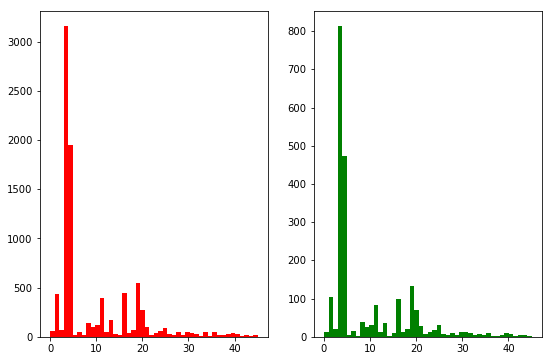

In [5]:
# 对训练标签做统计
n_bins = max(y_train) + 1

plt.figure(figsize=(9,6))
plt.subplot(121)
train_num,train_bins, _ = plt.hist(y_train, bins=n_bins, histtype='bar', facecolor='r')
train_pdf = train_num / np.sum(train_num)

plt.subplot(122)
test_num, test_bins, _  = plt.hist(y_test, bins=n_bins, histtype='bar', facecolor='g')
test_pdf = test_num / np.sum(test_num)

# 输出每种类别所对应的数量
print('{:^20}{:^20}{:^20}'.format('Class', 'Training Count', 'Test Count'))
for i, train_n, train_p, test_n, test_p in zip(range(n_bins), train_num, train_pdf, test_num, test_pdf):
    print('{:^20}{:>10}({:.2f}){:>10}({:.2f})'.format(int(i), int(train_n),train_p, int(test_n), test_p))

In [6]:
## 将数字转换为单词
word_index = reuters.get_word_index()
num_to_word = { value:key for (key, value) in word_index.items()}
def decode_review(num_to_word, review):
    # i - 3是因为0, 1, 2代表着'padding','start', 'unknow'， 因此单词的下标真正是从3开始的
    decoded = ' '.join( [num_to_word.get(i-3, '?') for i in review])
    return decoded
decode_review(num_to_word, x_train[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### 0.结论

+ 这是一个多类分类问题，每种类别的数量分布很不平衡，有的类别有几千个，但是有的类别只有十几个
+ 每条数据长度不一致，需要被统一长度

## 1. 定位问题

+ 输入数据：$x\in R^n$, $n$表示长度，$x_i$是一个数字，表示一个单词，不同的$x$，n的值不同
+ 输出：$y\in\{0, \dots, 45\}$, 每个数字表示一种类别
+ 问题归类：多类别分类问题

## 2.  衡量指标

+ 样本类型分布不均匀，是imbalanced data，可能用Precision对数据进行衡量比较OK

## 3. 验证策略

+ hold-out

## 4. 准备数据

+ 截断太长的数据，填充过短的数据

In [7]:
max_len = 500

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print('After Padding\nTraining data shape:{}, test data shape:{}'.format(x_train.shape, x_test.shape))

After Padding
Training data shape:(8982, 500), training labels shape:(8982,)


## 5. 基本模型

+ 首先确定一个基线，在这个问题中，我们利用随机猜测的力量来估计猜中的概率是多少，以这个概率作为基线。结果显示，基线大概为18%
+ 接下来，建立一个模型，能够打败基线即可。这里用上Embedding层。

In [15]:
# 确定基线，即靠猜
rand_results = y_test.copy()
np.random.shuffle(rand_results)

hits_array = rand_results == y_test
random_acc = np.sum(hits_array) / len(y_test)
print('Accuracy based on random is :{}'.format(random_acc))

Accuracy based on random is :0.18210151380231523


In [25]:
def build_based_model():
    model = models.Sequential()
    
    model.add(layers.Embedding(max_featuers, 32, input_length=max_len))
    model.add(layers.Flatten())
    model.add(layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model

In [24]:
model = build_based_model()


callback_list = [callbacks.EarlyStopping(patience=8),
                 callbacks.ModelCheckpoint('best_based_model.h5', save_best_only=True)]

model.fit(x_train, y_train, epochs=20, callbacks=callback_list, batch_size=16, validation_split=0.15)

Train on 7634 samples, validate on 1348 samples
Epoch 1/20
7634/7634 [==============================] - 10s 1ms/step - loss: 1.8541 - acc: 0.5312 - val_loss: 1.4829 - val_acc: 0.6521
Epoch 2/20
7634/7634 [==============================] - 3s 414us/step - loss: 0.8690 - acc: 0.7996 - val_loss: 1.2585 - val_acc: 0.7085
Epoch 3/20
7634/7634 [==============================] - 3s 399us/step - loss: 0.3951 - acc: 0.9230 - val_loss: 1.2860 - val_acc: 0.7122
Epoch 4/20
7634/7634 [==============================] - 3s 396us/step - loss: 0.2686 - acc: 0.9518 - val_loss: 1.3520 - val_acc: 0.7099
Epoch 5/20
7634/7634 [==============================] - 6s 784us/step - loss: 0.2179 - acc: 0.9572 - val_loss: 1.4452 - val_acc: 0.7010
Epoch 6/20
7634/7634 [==============================] - 3s 425us/step - loss: 0.2061 - acc: 0.9583 - val_loss: 1.3599 - val_acc: 0.7092
Epoch 7/20
7634/7634 [==============================] - 3s 406us/step - loss: 0.1906 - acc: 0.9580 - val_loss: 1.4439 - val_acc: 0.7062
E

## 6.调整参数

In [34]:
def build_model(dropout=0.5):
    model = models.Sequential()
    
    model.add(layers.Embedding(max_featuers, 512, input_length=max_len))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    return model

In [36]:
model = build_model()


callback_list = [callbacks.EarlyStopping(patience=8),
                 callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)]

model.fit(x_train, y_train, epochs=20, callbacks=callback_list, batch_size=32, validation_split=0.15)
model.evaluate(x_test, y_test)

Train on 7634 samples, validate on 1348 samples
Epoch 1/20
7634/7634 [==============================] - 18s 2ms/step - loss: 3.4759 - sparse_categorical_accuracy: 0.1969 - val_loss: 2.8408 - val_sparse_categorical_accuracy: 0.3984
Epoch 2/20
7634/7634 [==============================] - 17s 2ms/step - loss: 2.2078 - sparse_categorical_accuracy: 0.4700 - val_loss: 1.8516 - val_sparse_categorical_accuracy: 0.5364
Epoch 3/20
7634/7634 [==============================] - 17s 2ms/step - loss: 1.8520 - sparse_categorical_accuracy: 0.5400 - val_loss: 1.6885 - val_sparse_categorical_accuracy: 0.5645
Epoch 4/20
7634/7634 [==============================] - 16s 2ms/step - loss: 1.6485 - sparse_categorical_accuracy: 0.5849 - val_loss: 1.6602 - val_sparse_categorical_accuracy: 0.5809
Epoch 5/20
7634/7634 [==============================] - 18s 2ms/step - loss: 1.5075 - sparse_categorical_accuracy: 0.6180 - val_loss: 1.6275 - val_sparse_categorical_accuracy: 0.6098
Epoch 6/20
7634/7634 [===============

[1.3704577141963046, 0.70124666073018704]

### 加了Embedding层效果反而不如书上的例子，我们再试试书本上的例子吧

In [5]:

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
        
    return results

In [6]:
x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

print('After vectorize\nTraining data shape:{}, test data shape:{}'.format(x_train.shape, x_test.shape))

After vectorize
Training data shape:(8982, 10000), test data shape:(2246, 10000)


In [7]:
def build_naive_model():
    model = models.Sequential()
    
    model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [8]:
model = build_naive_model()

callback_list = [callbacks.EarlyStopping(patience=8),
                 callbacks.ModelCheckpoint('best_naive_model.h5', save_best_only=True)]

model.fit(x_train, y_train, epochs=20, callbacks=callback_list, batch_size=512, validation_split=0.15)
model.evaluate(x_test, y_test)

Train on 7634 samples, validate on 1348 samples
Epoch 1/20
7634/7634 [==============================] - 6s 791us/step - loss: 3.2955 - sparse_categorical_accuracy: 0.4396 - val_loss: 2.5913 - val_sparse_categorical_accuracy: 0.5364
Epoch 2/20
7634/7634 [==============================] - 3s 393us/step - loss: 2.0406 - sparse_categorical_accuracy: 0.5713 - val_loss: 1.7177 - val_sparse_categorical_accuracy: 0.6387
Epoch 3/20
7634/7634 [==============================] - 9s 1ms/step - loss: 1.4246 - sparse_categorical_accuracy: 0.6981 - val_loss: 1.4003 - val_sparse_categorical_accuracy: 0.7047
Epoch 4/20
7634/7634 [==============================] - 7s 945us/step - loss: 1.1209 - sparse_categorical_accuracy: 0.7588 - val_loss: 1.2393 - val_sparse_categorical_accuracy: 0.7300
Epoch 5/20
7634/7634 [==============================] - 7s 963us/step - loss: 0.9021 - sparse_categorical_accuracy: 0.8070 - val_loss: 1.1404 - val_sparse_categorical_accuracy: 0.7493
Epoch 6/20
7634/7634 [============

[1.0788633611089717, 0.79341050756901155]

### 尝试对书本的例子进行调参

In [7]:
def build_model():
    model = models.Sequential()
    reg = regularizers.l2(0.01)
    
    model.add(layers.Dense(64, activation='relu',kernel_initializer='he_normal',input_shape=(10000,)))
    model.add(layers.Dense(64, activation='relu',kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization(center=False, scale=False))
    model.add(layers.Dense(46, activation='softmax',kernel_initializer='he_normal'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [8]:
model = build_model()

callback_list = [callbacks.EarlyStopping(patience=50),
                 callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)]

model.fit(x_train, y_train, epochs=200, callbacks=callback_list, batch_size=64, validation_split=0.15)
model.evaluate(x_test, y_test)

Train on 7634 samples, validate on 1348 samples
Epoch 1/200
7634/7634 [==============================] - 8s 1ms/step - loss: 2.3248 - sparse_categorical_accuracy: 0.5317 - val_loss: 2.2482 - val_sparse_categorical_accuracy: 0.7255
Epoch 2/200
7634/7634 [==============================] - 1s 175us/step - loss: 1.3301 - sparse_categorical_accuracy: 0.7419 - val_loss: 1.4470 - val_sparse_categorical_accuracy: 0.7522
Epoch 3/200
7634/7634 [==============================] - 1s 176us/step - loss: 0.9740 - sparse_categorical_accuracy: 0.8027 - val_loss: 1.2019 - val_sparse_categorical_accuracy: 0.7737
Epoch 4/200
7634/7634 [==============================] - 1s 174us/step - loss: 0.7744 - sparse_categorical_accuracy: 0.8385 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.7834
Epoch 5/200
7634/7634 [==============================] - 1s 174us/step - loss: 0.6295 - sparse_categorical_accuracy: 0.8638 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.7841
Epoch 6/200
7634/7634 [======

Epoch 45/200
7634/7634 [==============================] - 1s 166us/step - loss: 0.1105 - sparse_categorical_accuracy: 0.9632 - val_loss: 1.2840 - val_sparse_categorical_accuracy: 0.8042
Epoch 46/200
7634/7634 [==============================] - 1s 169us/step - loss: 0.1172 - sparse_categorical_accuracy: 0.9598 - val_loss: 1.2637 - val_sparse_categorical_accuracy: 0.8056
Epoch 47/200
7634/7634 [==============================] - 1s 169us/step - loss: 0.1112 - sparse_categorical_accuracy: 0.9631 - val_loss: 1.2755 - val_sparse_categorical_accuracy: 0.8027
Epoch 48/200
7634/7634 [==============================] - 1s 172us/step - loss: 0.1132 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.3092 - val_sparse_categorical_accuracy: 0.7997
Epoch 49/200
7634/7634 [==============================] - 1s 170us/step - loss: 0.1086 - sparse_categorical_accuracy: 0.9615 - val_loss: 1.2921 - val_sparse_categorical_accuracy: 0.8027
Epoch 50/200
7634/7634 [==============================] - 1s 173us/ste

[1.3954193265121746, 0.79608192347248852]

## 总结
+ 调参好累，调了半天也